# Laboratorio 7. Predicción de datos con AutoGluon

## Entrenamiento del modelo

In [10]:
# Es necesario instalar autogluon
# En este caso solamente instalamos lo que vamos a utilizar
#!pip install autogluon.tabular

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from autogluon.tabular import TabularPredictor

### Limpieza de datos

Si bien el análisis exploratorio mostró valores atípicos (ceros donde no debería haber) y un desbalance entre clases, en clase se decidió que no se modificaría el set de datos.

### División de los datos

In [12]:
df = pd.read_csv("/content/diabetes.csv") # Ruta para google colab

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preparar datos para AutoGluon
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### Entrenamiento con AutoGluon

In [13]:
# Configuración del predictor con best_quality preset
predictor = TabularPredictor(
    label='Outcome',
    eval_metric='accuracy',
    path='./autogluon_models'
)

# Entrenamiento con configuración optimizada
predictor.fit(
    train_data=train_data,
    presets='best_quality',
    time_limit=300,  # 5 minutos para evitar ejecuciones largas
    verbosity=2
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Memory Avail:       10.45 GB / 12.67 GB (82.5%)
Disk Space Avail:   73.36 GB / 112.64 GB (65.1%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the d

### Evaluar con test

In [15]:
ag_preds = predictor.predict(test_data)
ag_acc = accuracy_score(test_data["Outcome"], ag_preds)
print(f"AutoGluon Accuracy: {ag_acc:.4f}")

AutoGluon Accuracy: 0.7468


### modelo base (regresión logística)

In [16]:
# Entrenamiento del modelo base (Regresión Logística)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predicciones del modelo base
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"Logistic Regression Accuracy:: {baseline_accuracy:.4f}")

Logistic Regression Accuracy:: 0.7143


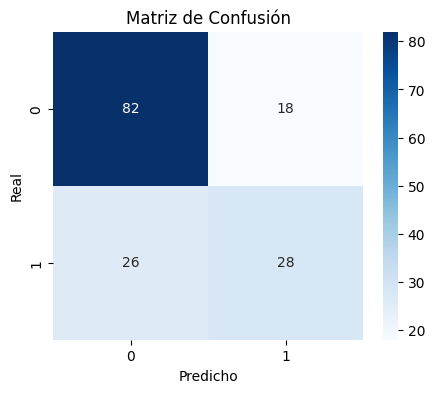

In [17]:
cm = confusion_matrix(y_test, baseline_predictions)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

## Verficar importancia de características

In [20]:
# Obtener importancia de características
feature_importance = predictor.feature_importance(test_data)
print("Importancia de Características:")
print(feature_importance)

Computing feature importance via permutation shuffling for 8 features using 154 rows with 5 shuffle sets...
	22.01s	= Expected runtime (4.4s per shuffle set)
	5.16s	= Actual runtime (Completed 5 of 5 shuffle sets)


Importancia de Características:
                            importance    stddev  ...  p99_high   p99_low
Glucose                   1.064935e-01  0.048723  ...  0.206815  0.006172
BMI                       3.116883e-02  0.009631  ...  0.051000  0.011338
Age                       2.727273e-02  0.016808  ...  0.061881 -0.007335
BloodPressure             2.207792e-02  0.018708  ...  0.060597 -0.016441
Pregnancies               5.194805e-03  0.019153  ...  0.044631 -0.034242
DiabetesPedigreeFunction -4.440892e-17  0.014520  ...  0.029897 -0.029897
SkinThickness            -3.896104e-03  0.008712  ...  0.014042 -0.021834
Insulin                  -5.194805e-03  0.005433  ...  0.005992 -0.016381

[8 rows x 6 columns]


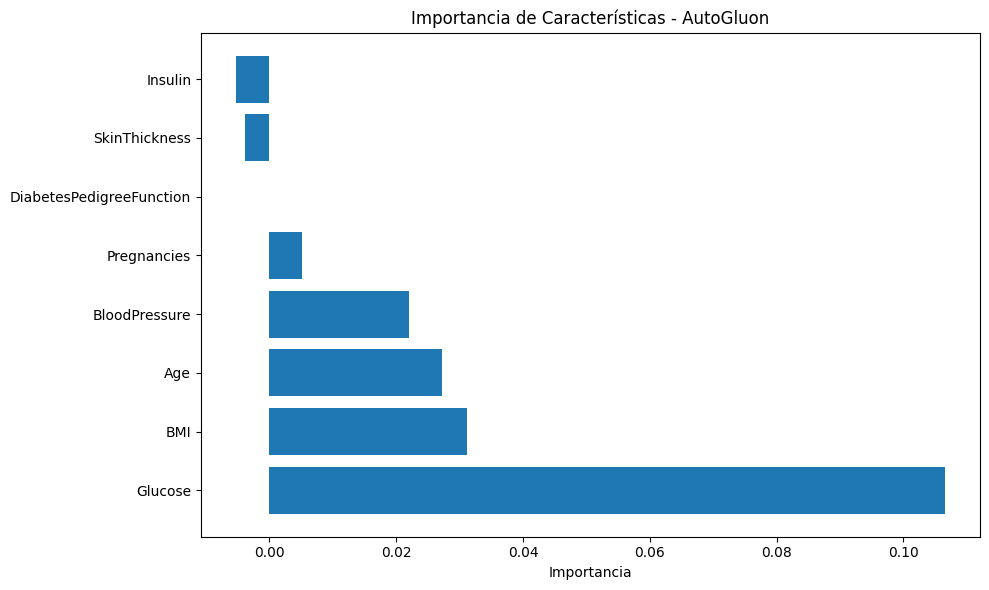

In [24]:
# Visualización de importancia de características
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance.index)
plt.xlabel('Importancia')
plt.title('Importancia de Características - AutoGluon')
plt.tight_layout()
plt.show()

## Evaluación del modelo

### Tabla de clasificación

In [25]:
# Obtener el leaderboard de modelos
leaderboard = predictor.leaderboard(test_data, silent=True)
print("Tabla de los Mejores Modelos:")
print(leaderboard)

Tabla de los Mejores Modelos:
                          model  score_test  ...  can_infer fit_order
0               LightGBM_BAG_L1    0.766234  ...       True         2
1            XGBoost_r89_BAG_L1    0.766234  ...       True        22
2                XGBoost_BAG_L1    0.759740  ...       True         8
3       RandomForestEntr_BAG_L1    0.753247  ...       True         4
4      RandomForest_r195_BAG_L1    0.753247  ...       True        19
5       RandomForestEntr_BAG_L2    0.753247  ...       True        28
6       RandomForestGini_BAG_L1    0.746753  ...       True         3
7            XGBoost_r33_BAG_L1    0.746753  ...       True        16
8               LightGBM_BAG_L2    0.746753  ...       True        26
9           WeightedEnsemble_L3    0.746753  ...       True        40
10         LightGBM_r131_BAG_L2    0.746753  ...       True        36
11      RandomForestGini_BAG_L2    0.746753  ...       True        27
12         LightGBMLarge_BAG_L2    0.746753  ...       True 

### Mejor modelo

In [26]:
# Identificar el mejor modelo
best_model = leaderboard.iloc[0]['model']
print(f"\nMejor modelo: {best_model}")
print(f"Accuracy del mejor modelo: {leaderboard.iloc[0]['score_val']:.4f}")


Mejor modelo: LightGBM_BAG_L1
Accuracy del mejor modelo: 0.7866


In [28]:
y_true = test_data["Outcome"]
y_pred = predictor.predict(test_data, model=best_model)
y_prob = predictor.predict_proba(test_data, model=best_model)[1]  # probabilidad de clase positiva

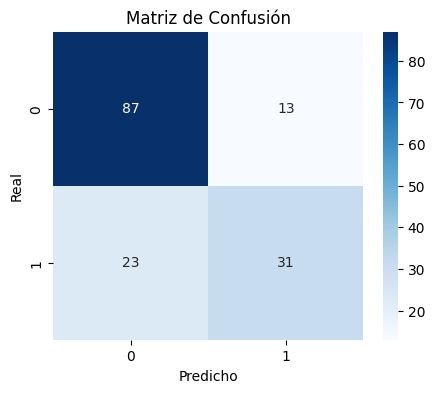

In [29]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Métricas adicionales

In [30]:
report = classification_report(y_true, y_pred, digits=4)
print("Reporte de Precisión, Recall y F1-score:\n")
print(report)

Reporte de Precisión, Recall y F1-score:

              precision    recall  f1-score   support

           0     0.7909    0.8700    0.8286       100
           1     0.7045    0.5741    0.6327        54

    accuracy                         0.7662       154
   macro avg     0.7477    0.7220    0.7306       154
weighted avg     0.7606    0.7662    0.7599       154



### curva ROC y AUC

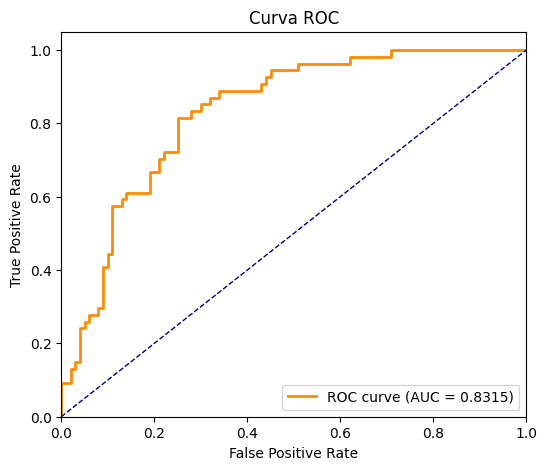

In [31]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()